<a href="https://www.kaggle.com/code/youssefmohhaj89/flood-prediction-100-accuracy?scriptVersionId=157476289" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import Binarizer

# **reviewing dataset**

In [2]:
df = pd.read_csv("/kaggle/input/flood-prediction-factors/flood.csv")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,5,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,6,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,2,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,9,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,7,7,6,5,3,3,4,4,3,4,0.475


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  CoastalVulnerabili

#### **converting probabilities to 1 & 0**

In [6]:
df["FloodProbability"] = np.where(df['FloodProbability'] > 0.5, 1, 0)

In [7]:
df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,5,10,7,4,2,3,4,3,2,6,0
1,8,4,5,7,7,9,1,5,5,4,6,9,2,6,2,1,1,9,1,3,0
2,3,10,4,1,7,5,4,7,4,9,2,7,4,4,8,6,1,8,3,6,1
3,4,4,2,7,3,4,1,4,6,4,9,4,2,6,6,8,8,6,6,10,1
4,3,7,5,2,5,8,5,2,7,5,7,7,6,5,3,3,4,4,3,4,0


In [8]:
df.isna().sum()

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [9]:
df.duplicated().sum()

0

# **checking the heatmap**

In [10]:
corr = df.corr()

<Axes: >

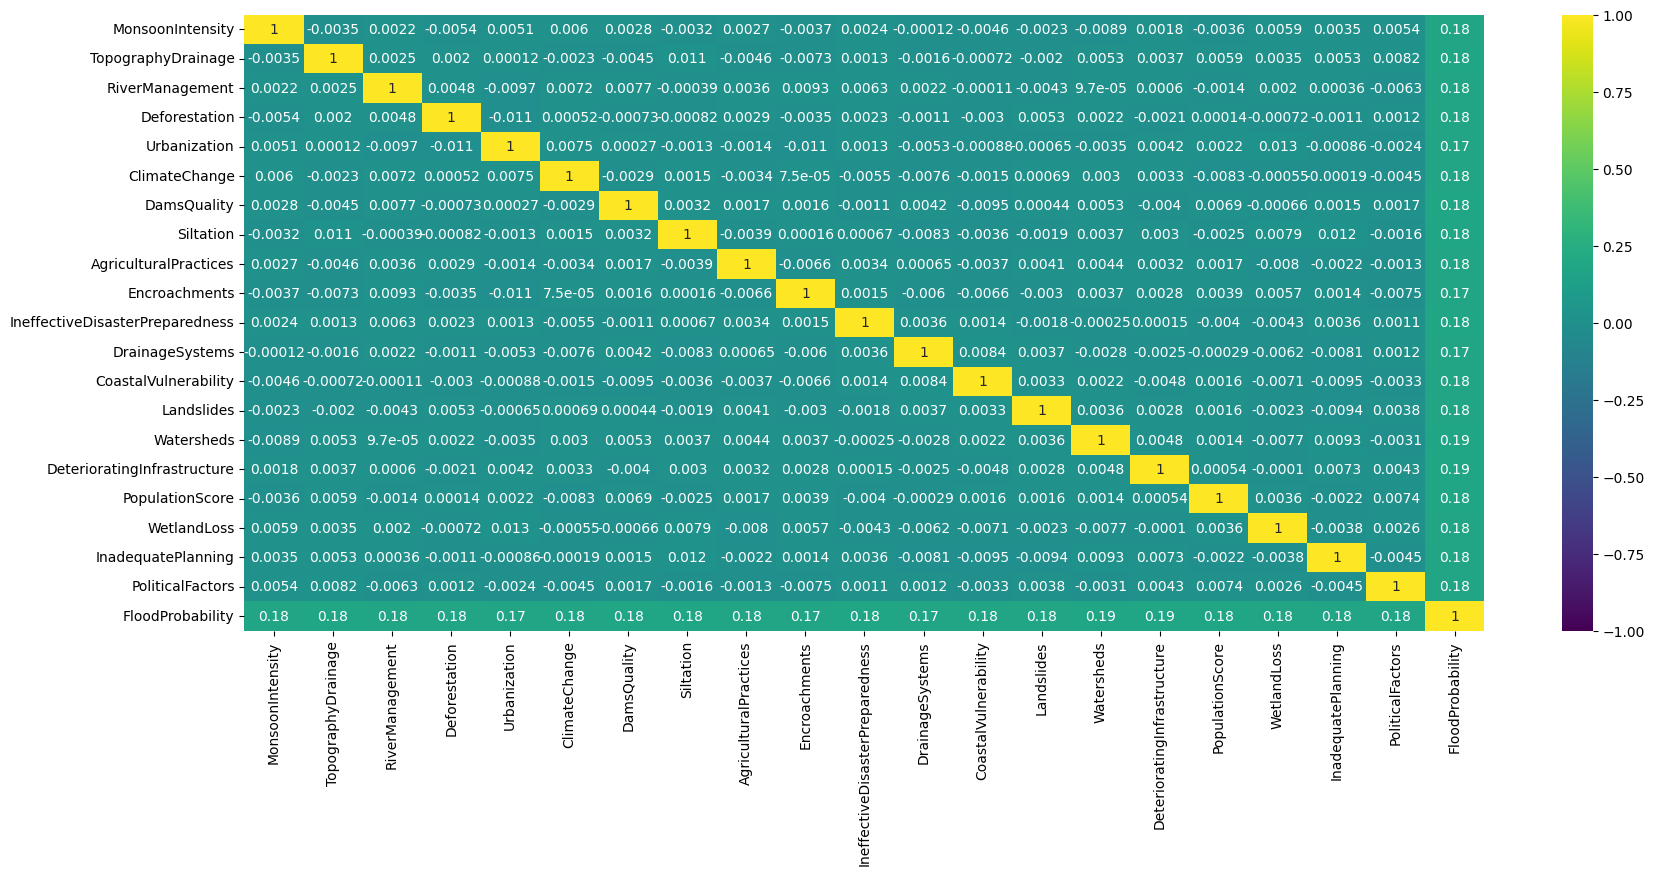

In [11]:
plt.figure(figsize=(20 , 8))
sns.heatmap(corr , vmin = -1 , vmax = 1 , cmap = "viridis" , annot = True)

# **checking for outliers**

<Axes: >

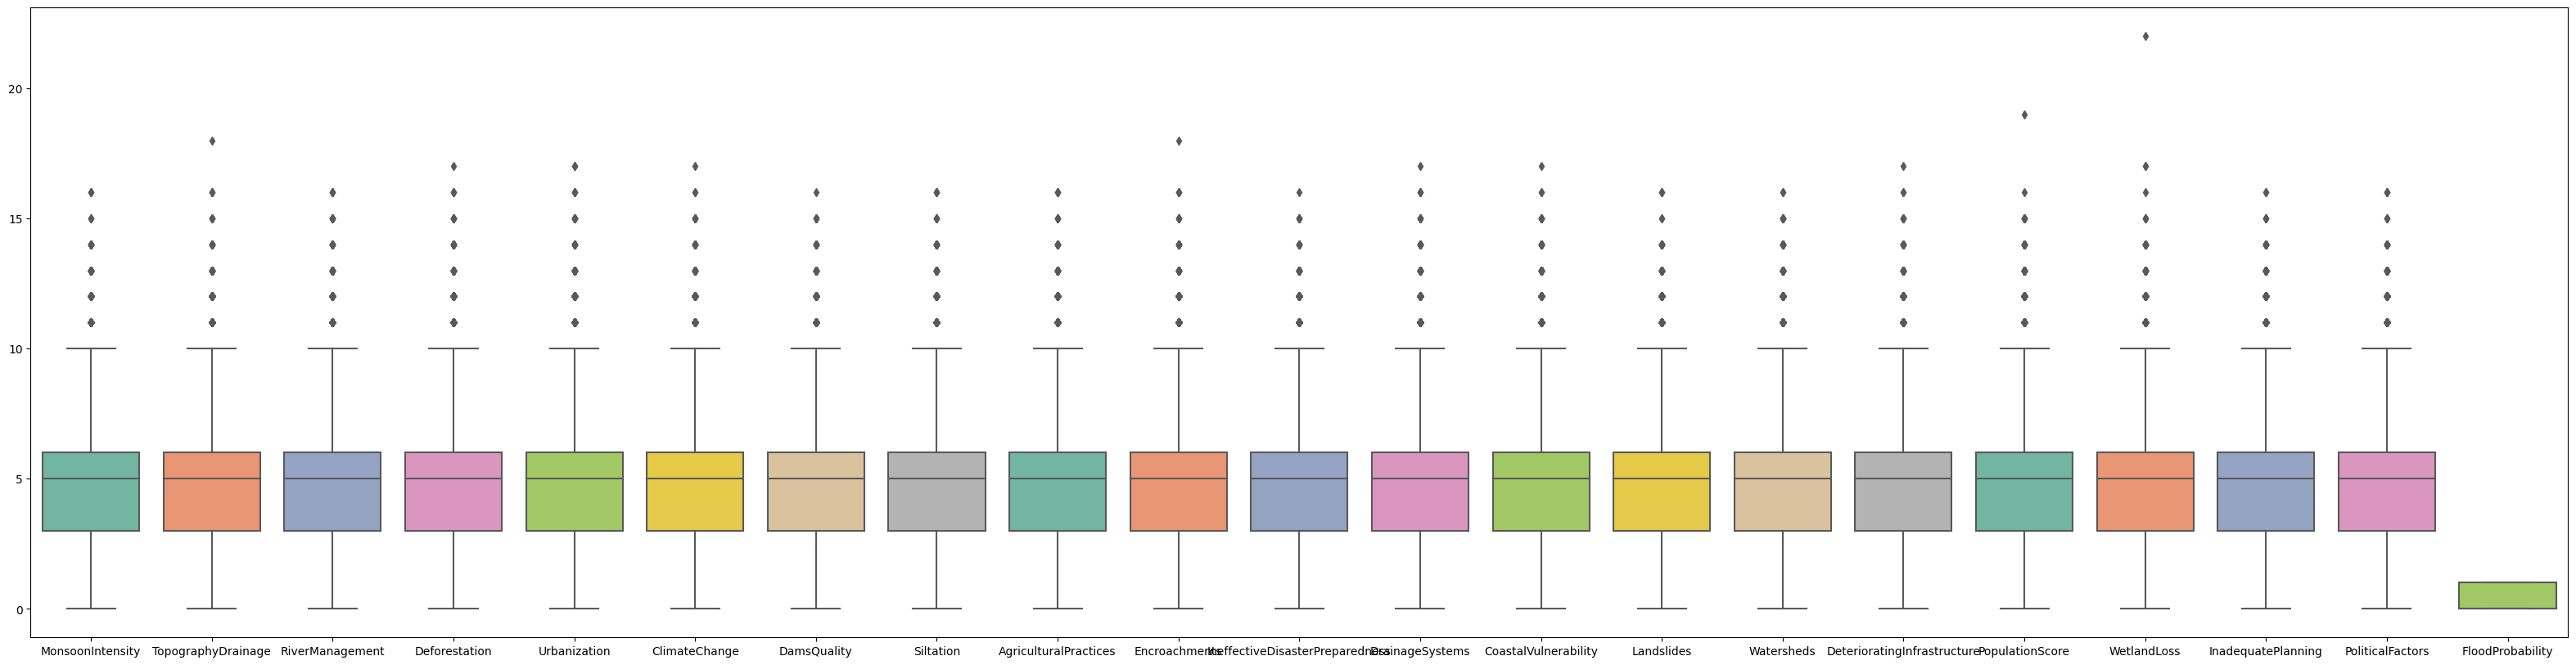

In [12]:
plt.figure(figsize=(40, 10))
sns.boxplot(data=df, orient="v", palette="Set2")

# **removing outliers using z-score method**

In [13]:
def z_score(df, column_name):
    
    x = df[column_name]
    
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = (x < lower_bound) | (x > upper_bound)
    
    df_cleaned = df[~outliers]
    
    return df_cleaned

In [14]:
df_cleaned = z_score(df , "MonsoonIntensity")

In [15]:
df_cleaned = z_score(df_cleaned , "TopographyDrainage")

In [16]:
df_cleaned = z_score(df_cleaned , "RiverManagement")

In [17]:
df_cleaned = z_score(df_cleaned , "Deforestation")

In [18]:
df_cleaned = z_score(df_cleaned , "Urbanization")

In [19]:
df_cleaned = z_score(df_cleaned , "ClimateChange")

In [20]:
df_cleaned = z_score(df_cleaned , "DamsQuality")

In [21]:
df_cleaned = z_score(df_cleaned , "Siltation")

In [22]:
df_cleaned = z_score(df_cleaned , "AgriculturalPractices")

In [23]:
df_cleaned = z_score(df_cleaned , "Encroachments")

In [24]:
df_cleaned = z_score(df_cleaned , "IneffectiveDisasterPreparedness")

In [25]:
df_cleaned = z_score(df_cleaned , "DrainageSystems")

In [26]:
df_cleaned = z_score(df_cleaned , "CoastalVulnerability")

In [27]:
df_cleaned = z_score(df_cleaned , "Landslides")

In [28]:
df_cleaned = z_score(df_cleaned , "Watersheds")

In [29]:
df_cleaned = z_score(df_cleaned , "DeterioratingInfrastructure")

In [30]:
df_cleaned = z_score(df_cleaned , "PopulationScore")

In [31]:
df_cleaned = z_score(df_cleaned , "WetlandLoss")

In [32]:
df_cleaned = z_score(df_cleaned , "InadequatePlanning")

In [33]:
df_cleaned = z_score(df_cleaned , "PoliticalFactors")

# **the dataset without outliers**

<Axes: >

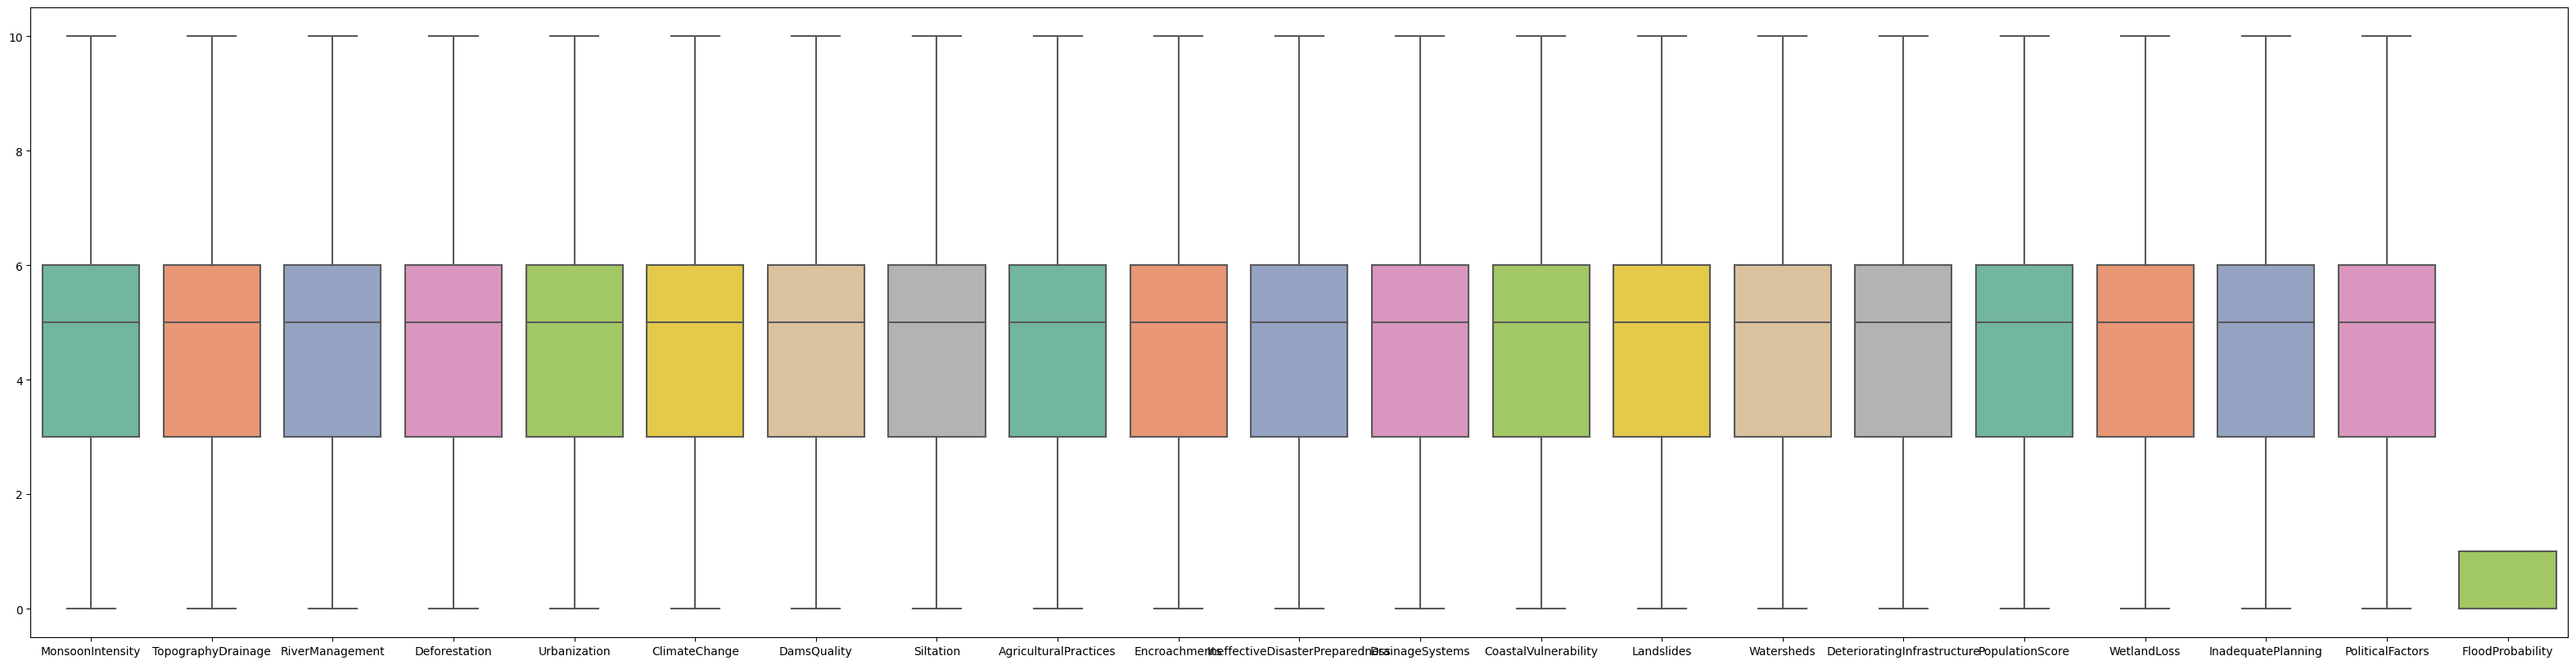

In [34]:
plt.figure(figsize=(40, 10))
sns.boxplot(data=df_cleaned, orient="v", palette="Set2")

# **dealing with imbalance dataset**

In [35]:
num_0 = (df_cleaned["FloodProbability"] == 0).sum()
num_1 = (df_cleaned["FloodProbability"] == 1).sum()

print("number of class 0: ",num_0)
print("number of class 1: ",num_1)

number of class 0:  22895
number of class 1:  14998


In [36]:
def balance_data(num_to_delete,df,name_of_col):
    
    class_0_rows = df[df[name_of_col] == 0]

    if num_to_delete > len(class_0_rows):
        df = df[df[name_of_col] != 0]
    else:

        rows_to_delete = class_0_rows.sample(n=num_to_delete, random_state=42).index

        df = df.drop(rows_to_delete)

    return df

In [37]:
df = balance_data(7897,df_cleaned,"FloodProbability")

In [38]:
num_0 = (df["FloodProbability"] == 0).sum()
num_1 = (df["FloodProbability"] == 1).sum()

print("number of class 0: ",num_0)
print("number of class 1: ",num_1)

number of class 0:  14998
number of class 1:  14998


In [39]:
x = df.drop("FloodProbability" , axis = 1)
y = df["FloodProbability"]

In [40]:
x = np.array(x)
y = np.array(y)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3 , random_state=42)

In [42]:
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(20997, 20) (8999, 20) (20997,) (8999,)


In [43]:
yy = np.concatenate([y_train, y_test])

# **the data is balanced**

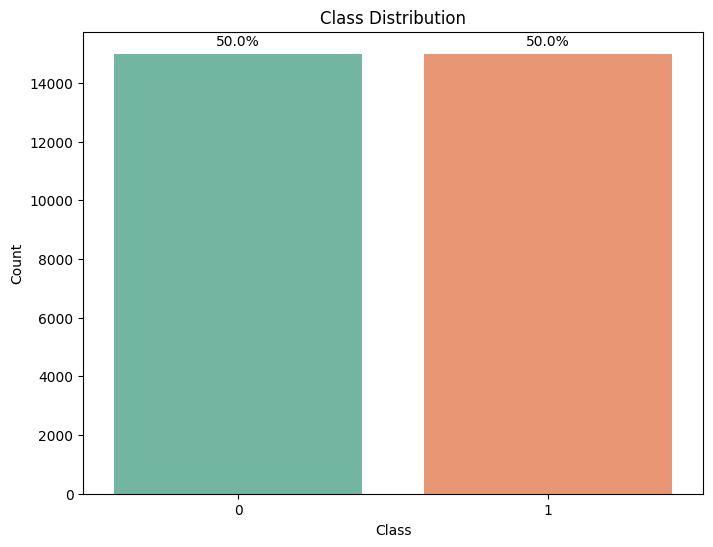

In [44]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x=yy.ravel(), palette='Set2')

total = len(yy)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01 * total, f'{height/total:.1%}', ha="center")

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


# **training phase**

#### **logistic regression 100%**

In [45]:
logreg = LogisticRegression(max_iter=2000,random_state=42)
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification_rep)

1.0
[[4477    0]
 [   0 4522]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4477
           1       1.00      1.00      1.00      4522

    accuracy                           1.00      8999
   macro avg       1.00      1.00      1.00      8999
weighted avg       1.00      1.00      1.00      8999



#### **knn 84%**

In [46]:
knn = KNeighborsClassifier(n_neighbors= 8)
knn.fit(x_train , y_train)
y_pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification_rep)

0.8444271585731749
[[4166  311]
 [1089 3433]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      4477
           1       0.92      0.76      0.83      4522

    accuracy                           0.84      8999
   macro avg       0.85      0.84      0.84      8999
weighted avg       0.86      0.84      0.84      8999



#### **XGBoost 92%**

In [47]:
xgboost = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42)

xgboost.fit(x_train, y_train)
y_pred = xgboost.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification_rep)

0.919991110123347
[[4106  371]
 [ 349 4173]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4477
           1       0.92      0.92      0.92      4522

    accuracy                           0.92      8999
   macro avg       0.92      0.92      0.92      8999
weighted avg       0.92      0.92      0.92      8999

